<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#teste-de-sanidade" data-toc-modified-id="teste-de-sanidade-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>teste de sanidade</a></span></li></ul></div>

# setup

In [47]:
import datetime
import gc
import json
import os
import pprint
import warnings
from io import BytesIO

import folium
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from folium.plugins import HeatMap
from IPython.display import display
from selenium import webdriver
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.interpolate import griddata

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [3]:
experiment_name = "wildfire_spread"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# data

In [126]:
gdf = gpd.read_file("../data/01_raw/DL_FIRE_J1V-C2_401899/fire_nrt_J1V-C2_401899.shp", rows=1000000)

In [130]:
display(gdf.head())
print(gdf.shape)

_col = "CONFIDENCE"
display(gdf[_col].value_counts())

# filter only data with high confidence to be wildfires (ref: https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/vnp14imgtdlnrt#ed-viirs-375m-attributes)
gdf = gdf.loc[gdf["CONFIDENCE"] != "l", :].copy()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,geometry
0,-4.68031,-48.52492,306.6,0.47,0.64,2019-12-04,0348,1,VIIRS,n,2.0NRT,289.4,0.9,N,POINT (-48.52492 -4.68031)
1,-6.54356,-37.41228,327.5,0.39,0.36,2019-12-04,0348,1,VIIRS,n,2.0NRT,294.4,4.6,N,POINT (-37.41228 -6.54356)
2,-6.54410,-37.40876,324.8,0.39,0.36,2019-12-04,0348,1,VIIRS,n,2.0NRT,295.8,4.6,N,POINT (-37.40876 -6.54410)
3,-5.57868,-43.44279,314.7,0.41,0.45,2019-12-04,0348,1,VIIRS,n,2.0NRT,291.4,2.1,N,POINT (-43.44279 -5.57868)
4,-5.31945,-45.06604,315.9,0.53,0.50,2019-12-04,0348,1,VIIRS,n,2.0NRT,292.0,2.9,N,POINT (-45.06604 -5.31945)


(913964, 15)


CONFIDENCE
n    846591
h     67373
Name: count, dtype: int64

In [135]:
SAO_PAULO_EXTENT = [-53, -44, -25, -20]
GLOBAL_LAT = gdf["LATITUDE"].mean()
GLOBAL_LON = gdf["LONGITUDE"].mean()

grid_lon, grid_lat = np.mgrid[
    SAO_PAULO_EXTENT[0]:SAO_PAULO_EXTENT[1]:200j, 
    SAO_PAULO_EXTENT[2]:SAO_PAULO_EXTENT[3]:200j
]

# only sao paulo and surrounding area
agg_gdf = gdf.loc[
    (gdf["LATITUDE"] >= SAO_PAULO_EXTENT[2]) & (gdf["LATITUDE"] <= SAO_PAULO_EXTENT[3]) & 
    (gdf["LONGITUDE"] >= SAO_PAULO_EXTENT[0]) & (gdf["LONGITUDE"] <= SAO_PAULO_EXTENT[1])
# ].groupby(['ACQ_DATE', 'ACQ_TIME'])
].groupby('ACQ_DATE')

datetime_measurements = dict()

for (acq_date), group in tqdm.tqdm(agg_gdf):
    _dt = datetime.datetime.strptime(f"{acq_date}", "%Y-%m-%d")
    datetime_measurements[_dt] = len(group)


100%|██████████| 279/279 [00:00<00:00, 1170.97it/s]


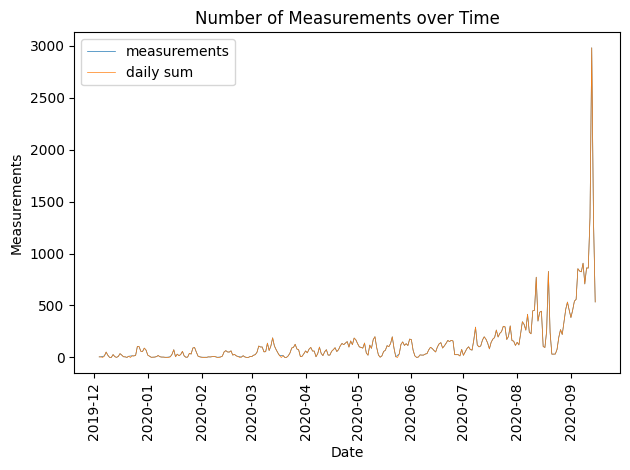

In [136]:
df = pd.DataFrame(datetime_measurements.items(), columns=['datetime', 'measurements'])
df = df.set_index('datetime')

fig, ax1 = plt.subplots()

ax1.plot(df.index, df['measurements'], label="measurements", linewidth=0.5)
ax1.plot(df.resample('D').sum().index, df.resample('D').sum()['measurements'], label="daily sum", linewidth=0.5)

ax1.xaxis.set_major_locator(mpl.dates.DayLocator())
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

ax1.set_title("Number of Measurements over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Measurements")
ax1.legend()

ax1.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

plt.tight_layout()
plt.savefig(f"{folder_path}/number_over_time.png", dpi=300, bbox_inches='tight')

  0%|          | 0/279 [00:00<?, ?it/s] 41%|████      | 115/279 [00:59<01:24,  1.94it/s]


KeyboardInterrupt: 

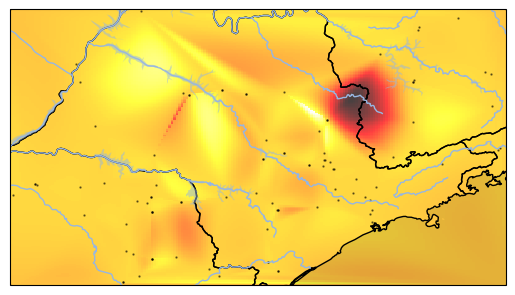

In [137]:
# for (acq_date, acq_time), group in tqdm.tqdm(agg_gdf):
#     _dt = datetime.datetime.strptime(f"{acq_date} {acq_time}", "%Y-%m-%d %H%M")
#     datetime_measurements[_dt] = len(group)
#     print(_dt, len(group))
for (acq_date), group in tqdm.tqdm(agg_gdf):
    _dt = datetime.datetime.strptime(f"{acq_date}", "%Y-%m-%d")
    datetime_measurements[_dt] = len(group)

    group = pd.concat([
        group,
        pd.DataFrame({
            "LATITUDE": [SAO_PAULO_EXTENT[2], SAO_PAULO_EXTENT[3], SAO_PAULO_EXTENT[2], SAO_PAULO_EXTENT[3]],
            "LONGITUDE": [SAO_PAULO_EXTENT[0], SAO_PAULO_EXTENT[0], SAO_PAULO_EXTENT[1], SAO_PAULO_EXTENT[1]],
            "BRIGHTNESS": [0, 0, 0, 0]
        })
    ], ignore_index=True)

    fname = f"heatmap_{_dt.strftime('%Y-%m-%d')}"

    fig = plt.figure()
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    ax.set_extent(SAO_PAULO_EXTENT, crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.OCEAN)

    grid_data = griddata(
        (group["LONGITUDE"], group["LATITUDE"]), 
        group["BRIGHTNESS"], 
        (grid_lon, grid_lat), 
        method="cubic"
    )
    heatmap = ax.pcolormesh(grid_lon, grid_lat, grid_data, transform=ccrs.PlateCarree(), cmap="hot", alpha=0.75)

    ax.scatter(group["LONGITUDE"], group["LATITUDE"], transform=ccrs.PlateCarree(), s=0.5, c="black", alpha=0.5)

    # save
    fig.savefig(f"{folder_path}/{fname}.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
    plt.close(fig)


# teste de sanidade

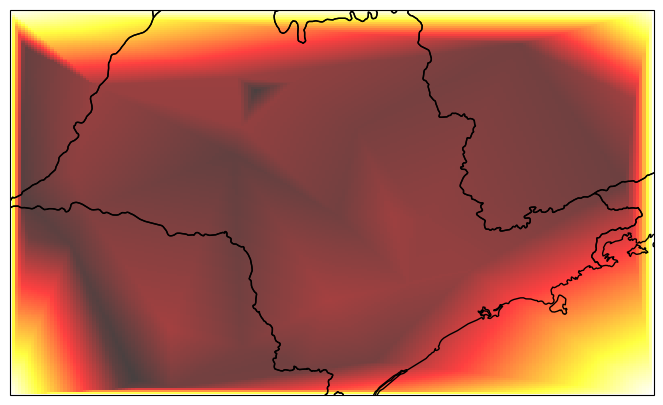

In [112]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(
    projection=ccrs.Mercator(
        central_longitude=GLOBAL_LON,
    )
)
ax.set_global()

# The state of São Paulo in Brazil is roughly bounded by the following geographical coordinates:
    # Western Longitude: -53.0
    # Eastern Longitude: -44.0
    # Southern Latitude: -25.0
    # Northern Latitude: -20.0
brazil_extent = [-74, -34, -34, 6]
sao_paulo_extent = [-53, -44, -25, -20]

ax.set_extent(sao_paulo_extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

# filtering sao paulo
subgdf = gdf.loc[
    (gdf["LATITUDE"] >= sao_paulo_extent[2]) & 
    (gdf["LATITUDE"] <= sao_paulo_extent[3]) & 
    (gdf["LONGITUDE"] >= sao_paulo_extent[0]) & 
    (gdf["LONGITUDE"] <= sao_paulo_extent[1])
].copy().sample(30)

# contour plot
grid_lon, grid_lat = np.mgrid[
    sao_paulo_extent[0]:sao_paulo_extent[1]:200j, 
    sao_paulo_extent[2]:sao_paulo_extent[3]:200j
]
# add sao paulo max, min lat,lon box to data
subgdf = pd.concat([
    subgdf,
    pd.DataFrame({
        "LATITUDE": [sao_paulo_extent[2], sao_paulo_extent[3], sao_paulo_extent[2], sao_paulo_extent[3]],
        "LONGITUDE": [sao_paulo_extent[0], sao_paulo_extent[0], sao_paulo_extent[1], sao_paulo_extent[1]],
        "BRIGHTNESS": [0, 0, 0, 0]
    })
], ignore_index=True)
grid_data = griddata((subgdf["LONGITUDE"], subgdf["LATITUDE"]), subgdf["BRIGHTNESS"], (grid_lon, grid_lat), method="linear")

heatmap = ax.pcolormesh(grid_lon, grid_lat, grid_data, transform=ccrs.PlateCarree(), cmap="hot_r", alpha=0.75)
# ax.contour(
#     grid_lon, 
#     grid_lat, 
#     grid_data, 
#     transform=ccrs.PlateCarree(),
#     colors="black",
#     alpha=0.5,
#     linewidths=0.5,
#     levels=5, 
# )
# ax.contourf(
#     grid_lon, 
#     grid_lat, 
#     grid_data, 
#     transform=ccrs.PlateCarree(),
#     cmap="hot_r",
#     levels=5,
#     alpha=0.5

# )
# ax.scatter(
#     subgdf["LONGITUDE"], 
#     subgdf["LATITUDE"], 
#     c=subgdf["BRIGHTNESS"],
#     transform=ccrs.PlateCarree(), 
#     s=100 ,
#     marker="s",
#     alpha=0.5
# )
# plt.colorbar(heatmap, ax=ax, shrink=0.5)

# meshgrid_brightness = subgdf.pivot_table(index="LATITUDE", columns="LONGITUDE", values="BRIGHTNESS")
# ax.contourf(meshgrid_brightness.columns, meshgrid_brightness.index, meshgrid_brightness.values, 50, transform=ccrs.PlateCarree(), cmap="hot_r")

plt.show()

In [ ]:
GLOBAL_LAT = gdf["LATITUDE"].mean()
GLOBAL_LON = gdf["LONGITUDE"].mean()

agg_gdf = gdf.groupby(['ACQ_DATE', 'ACQ_TIME'])

datetime_measurements = dict()

for (acq_date, acq_time), group in agg_gdf:
    _dt = datetime.datetime.strptime(f"{acq_date} {acq_time}", "%Y-%m-%d %H%M")
    datetime_measurements[_dt] = len(group)
    heatmap_data = [[row["LATITUDE"], row["LONGITUDE"]] for _, row in group.iterrows()]
    fname = f"heatmap_{_dt.strftime('%Y-%m-%d')}.html"

    m = folium.Map(
        location=[GLOBAL_LAT, GLOBAL_LON],
        zoom_start=5,
    )
    HeatMap(heatmap_data).add_to(m)

    m.save(f"{folder_path}/{fname}")

    html_path = html_file_path = os.path.abspath(f"{folder_path}/{fname}")

    webdriver = webdriver.Firefox()
    webdriver.get(f"file://{html_path}")
    webdriver.save_screenshot(f"{folder_path}/{fname}.png")
    webdriver.close()

    break  


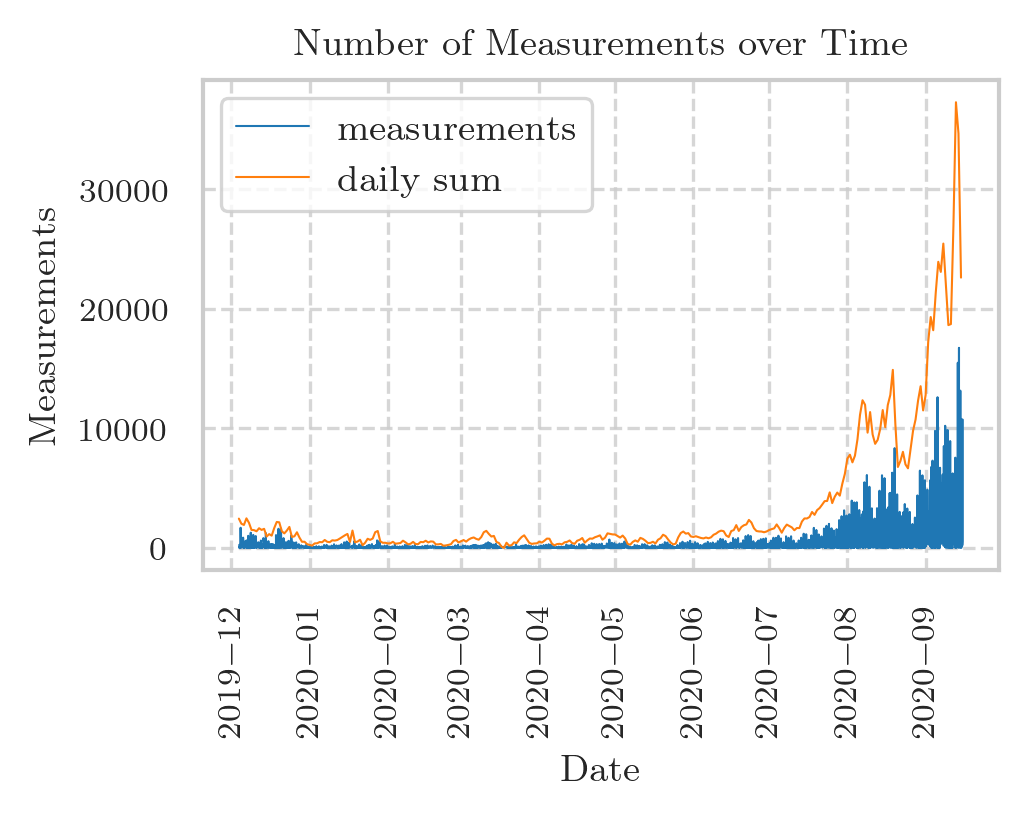

In [58]:
df = pd.DataFrame(datetime_measurements.items(), columns=['datetime', 'measurements'])
df = df.set_index('datetime')

fig, ax1 = plt.subplots()

ax1.plot(df.index, df['measurements'], label="measurements", linewidth=0.5)
ax1.plot(df.resample('D').sum().index, df.resample('D').sum()['measurements'], label="daily sum", linewidth=0.5)

ax1.xaxis.set_major_locator(mpl.dates.DayLocator())
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

ax1.set_title("Number of Measurements over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Measurements")
ax1.legend()

ax1.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

plt.tight_layout()
plt.savefig(f"{folder_path}/number_over_time.png", dpi=300, bbox_inches='tight')

.